In [1]:
'''importing libraries'''
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.utils as kutils
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

# suppress scintific notation warnings in numpy
np.set_printoptions(suppress=True)
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc

In [2]:
'''Importing the data'''
labels = pd.read_csv('../Data/Labels.csv')['Label']
data = np.load('../Data/images.npy')
print(labels.shape)
print(data.shape)
if labels.shape[0]==data.shape[0]:
    print('The number of labels and number of images correspond')
else:
    print('Check input data')

(4750,)
(4750, 128, 128, 3)
The number of labels and number of images correspond


In [3]:
'''Printing the categories and storing the number of classes'''
categories = labels.unique()
print(categories)
nclass = np.size(categories)
print('\nNumber of classes = ', nclass)

['Small-flowered Cranesbill' 'Fat Hen' 'Shepherds Purse' 'Common wheat'
 'Common Chickweed' 'Charlock' 'Cleavers' 'Scentless Mayweed' 'Sugar beet'
 'Maize' 'Black-grass' 'Loose Silky-bent']

Number of classes =  12


In [4]:
'''One hot encoding to make labels data into 2D matrix of categorical variables'''
encoder = preprocessing.LabelEncoder()
encoder.fit(labels)
labels_transformed = encoder.transform(labels)
labels_cat = kutils.to_categorical(labels_transformed)

print(labels_cat.shape)
print(labels_cat)

(4750, 12)
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
'''Splittling the data into test and train datasets'''
x_train,x_valid,y_train,y_valid = train_test_split(data, labels_cat,test_size=0.3,random_state=1,stratify=labels_cat)

In [6]:
y_train.shape

(3325, 12)

<AxesSubplot:>

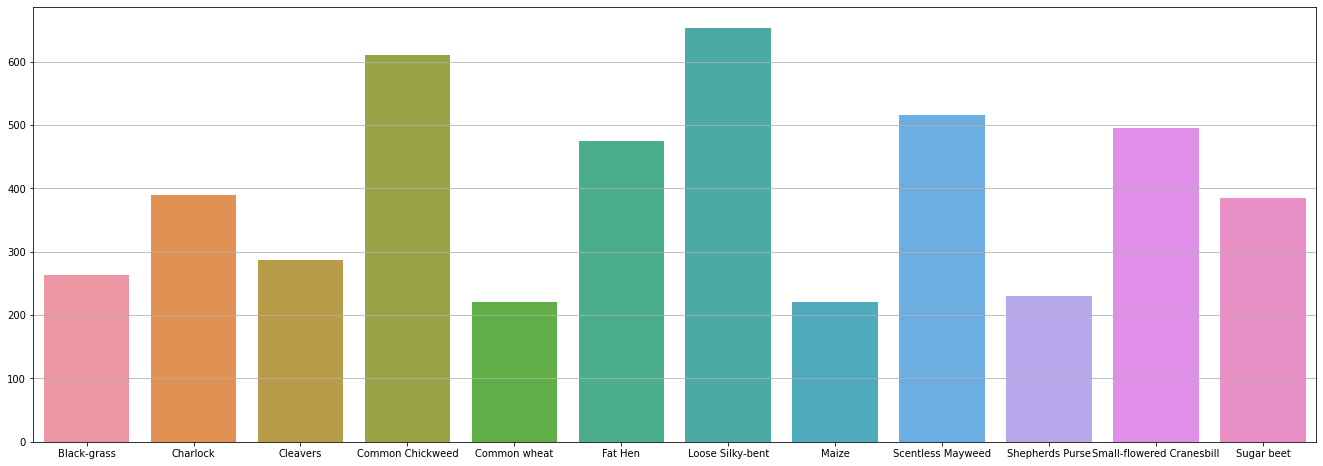

In [7]:
'''Visualizing the label data and its categories'''
ytrain_arr = np.array(labels)
np.unique(ytrain_arr.flatten(), return_counts = True)[0]
plt.figure(figsize=(23,8))
plt.grid()
sns.barplot(np.unique(ytrain_arr.flatten(), return_counts = True)[0], np.unique(ytrain_arr.flatten(), return_counts = True)[1])

In [8]:
x_train = x_train.astype('float32') # Conversion to float type from integer type.
x_valid = x_valid.astype('float32')
x_train = x_train/255.0 # Division by 255
x_valid = x_valid/255.0

In [9]:
tf.keras.backend.clear_session()
#sequential model initializing
model = Sequential()
#adding 1st convolution layer with 64 filters and imput shape 128 x128x3 with relu function
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(128, 128, 3), activation='relu'))
#normalising batch
model.add(BatchNormalization(axis=3))
#adding 2nd convolution layer with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
#maxpooling
model.add(MaxPooling2D((2, 2)))
#normalising batch
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
#adding 3rd convolution layer with 32 filters
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
#normalising batch
model.add(BatchNormalization(axis=3))
#adding 4th convolution layer with 32 filters
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
#maxpooling
model.add(MaxPooling2D((2, 2)))
#normalising batch
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))
# Global Max pooling layer
model.add(GlobalMaxPool2D())

#flattening layer
model.add(Flatten())
#Dense layer
#adding 1 st dense layer
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#adding 2 nd dense layer
model.add(Dense(50, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#adding dense layer with number of outputs = nclass with softmax function
model.add(Dense(nclass, activation='softmax'))

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('cifar_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto')

In [14]:
# initiate Adam optimizer
optA = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optA, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_history=model.fit(x_train, y_train, epochs=100, validation_data=(x_valid,y_valid),
                        shuffle=True, verbose=1, callbacks=[early_stopping,model_checkpoint])

Epoch 1/100
 51/104 [=============>................] - ETA: 2:11 - loss: 3.4521 - accuracy: 0.1066

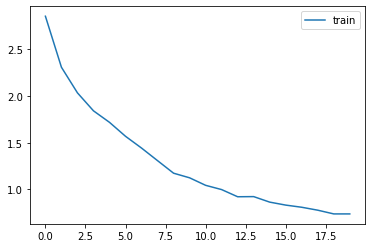

In [212]:
# plot training history
plt.plot(model_history.history['loss'], label='train')
#plt.plot(model_history.history['val_loss'], label='test')
plt.legend()
plt.show()